# Not Safe for Work (NSFW) media Classifier for Wikimedia Commons

***


## Purpose

This report addresses the following micro task:

* T264056: Comparison of Existing NSFW Classifiers

***

## Project scope

Wikimedia Commons is an online repository of free-use images, sounds, other media, and JSON files. Anyone can upload media to the Commons portal. The uploads are moderated by members and volunteers of the foundation manually. This project aims to build a classifier that can flag NSFW images/media for review. 

The meaning of the term **NSFW** is somewhat subjective and relates more to the potential shock value of the content rather than to the nature of the content itself. It is also context-depedent: finding pornographic videos on PornHub is not shocking but expected.

While pornography, graphic violence, death, torture, mutilations, and a long etc. could all be considered to fall under the NSFW umbrella, in the context of NSFW classfiers, the first of these categories is the one most commonly addressedd in the scientific literature. 

To the best of my knowledge, there has not been any attempt to date to create an end-to-end NSFW classifier that takes in an image (or other media) pertaining to a broad range of NSFW categories and spits out a NSFW/SFW label. In reality, this would most likely require an ensemble of classifiers, each making a prediction about their respective category. As most of the existing literature deals exclusively with NSFW as meaning pornography/sexually explicit, this is also the **working definition** I will be adopting throughout the rest of this report.

***

## Some preliminary considerations 

For the NSFW classifier to be useful, it must not only be accurate (enough) but also practical:

* The architecture should be light-weight enough to ensure a reasonable inference time and memory footprint on (probably) lower-to-mid end hardware. 
* It shouldn't take days/weeks to train, as that would make rapid iteration and fine-tuning infeasible.
* Easy to train: some architectures are more finicky than others.
* It should be robust to real-world conditions such as different images sizes/resolutions and if at all possible, resistant to adversarial attacks, although this consideration could possibly be left as a to-do for a later stage of the project.

The above suggests that a trade-off between accuracy (or whatever other evaluation metric is chosen), and performance will most likely have to be made.

Unfortunately for us, most papers are mainly concerned with beating the current state-of-the-art rather than designing real-world applications. Performance in terms of inference speed and training time are either not mentioned at all, or very difficult to directly compare as they are often hardware-specific. Invariably however, deeper architectures with more parameters are both more computationaly expensive and more difficult to train.

***

## T264056: Comparison of Existing NSFW Classifiers

**Convolutional neural networks** (ConvNets/CNNs) have become the de-facto method for image classification since AlexNet was proposed by [Kriszhevsky et al.](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) in 2012. Other approaches have been used for pornography detection in the past, most notably [skin-based methods](https://www.naun.org/multimedia/NAUN/computers/20-462.pdf), and handcraft feature-based using the visual [Bag-of-Visual-Words (BoVW)](https://www.researchgate.net/publication/220928405_Bag-of-visual-words_models_for_adult_image_classification_and_filtering), but I will not discuss them here as they are rarely the chosen approach today. Another approach that I haven't seen applied to this specific domain, but that could be worth investigating, is using a ConvNet for feature extraction followed by a SVM for classification.

### Task-specific classifiers: Yahoo OpenNSFW

In 2016, Yahoo proposed a [deep learning solution based on ResNet-50-thin architecture](https://yahooeng.tumblr.com/post/151148689421/open-sourcing-a-deep-learning-solution-for) for pornographic image detection. The model was first **pre-trained on ImageNet 1000 class dataset**. To adapt the ResNet-50-thin to a binary
classifier, only the last layer was replaced with a two nodes fully-connected layer. It was then fine-tuned on a custom NSFW dataset. This model has been released as open-source and successfully used by different teams to obtain accuracies in the range of 90-96%. It can be used as-is, or further fine-tuned by training on a custom dataset. This model is lightweight in terms of runtime (< 0.5 sec on CPU) and memory (~23 MB).

Below is a simplified overview of the model. <br> [source](http://gvis.unileon.es/wp-content/uploads/2020/06/arxiv_2005.08766.pdf)

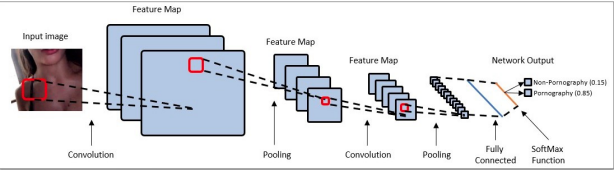

[This](http://gvis.unileon.es/wp-content/uploads/2020/06/arxiv_2005.08766.pdf) recent paper makes an attempt at evaluating the **performance at inference time** of an Adult Pornography Classifier on different types of hardware and operating systems. Their evaluation dataset consisted of 6000 randomly selected images from the [Pornography Database](https://sites.google.com/site/pornographydatabase/) (Side note: this database is often used for benchmarking NSFW classifiers and is also referred to as **NPDI** in the literature). The main results are displayed below.

* On **GPU**, it took on average ~80s to process 6000 images, which gives a processing capacity of **4500 images/min**.
* On **CPU**, the average time was ~500s for 6000 images, which gives a processing capacity of **720 images/min**.

For comparison, a **human operator** using a UI specifically designed for binary content labeling is able to process around **12 images/min** (from personal experience working on data annotation projects).

Another result from the same paper is that deploying the APD on an Ubuntu OS turned out to be quite a bit faster than on Windows 10 in terms of prediction time. Ubuntu OS was, at least, 5 and 2 times faster than Windows 10 in CPU and GPU machines, respectively.

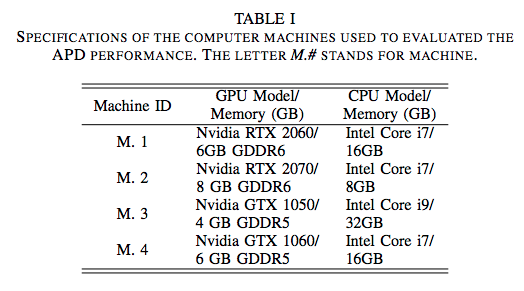

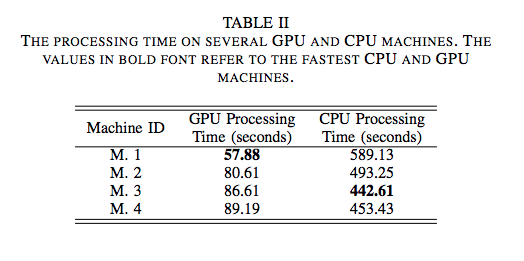

To the best of my knowledge, Yahoo OpenNSFW is the only task-specific (i.e. pornography) classifier that exists as open source. Other deep models in the literature either build upon this one, or are developed by using other pre-trained architectures and fine-tuned on custom NSFW datasets.

**Pros:**

* Good accuracy 
* Relatively lightweight
* Small dataset needed for additional fine-tuning
* While somewhat "outdated" by DL standards, it's still used in recent publications and applications
* Could save us time in the model-development phase, thus making it possible to concentrate our efforts on making the application work in practice. 
* While the original model was built on the Caffe framework (which could maybe be seen as less desirable), there's an open-source Tensorflow version available on GitHub.

**Cons:**

* No access to the NSFW dataset that was used to train on, and no guarantee that there will be a good enough match between our test data and the distribution of the training data. 
* Potentially more difficult to debug
* Potentially more difficult to customize than a from-scratch model
* Expects fixed-sized images (256 x 256 px). "Shaving off" enough layers from the head of the pre-trained model in order to modify it to make it work with images of any size without having to preprocess them in ways that entail information loss and image distortion (cropping, scaling...) would also defeat the purpose of using the model in the first place, as the Fully Connected layer would have to be scrapped and retrained.
* The Tensorflow version [available on GitHub](https://github.com/mdietrichstein/tensorflow-open_nsfw) is written with version 1.X and is thus slightly outdated. Furthermore, only jpeg images are supported. 
***

### Transfer-learning using other architectures

Below is a comparision of different ConvNet architectures in terms of accuracy, performance (number of operations), and model size (number of parameters). [source](https://core.ac.uk/download/pdf/157810617.pdf)

We see here that the ResNet-50 architecture Yahoo's OpenNSFW is based on offers a good trade-off between model size (~25M parameters [source](https://keras.io/api/applications/)), performance and accuracy. 

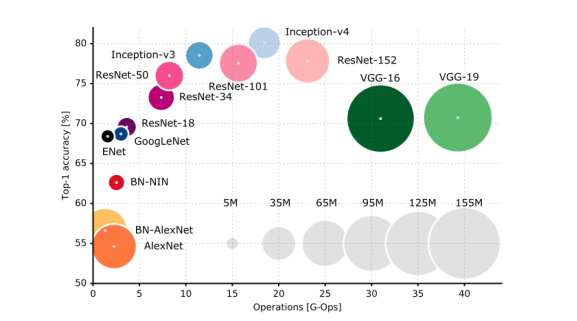
***

Below is a general overview of different model architectures commonly used in computer vision, many implementations of which can be found pre-trained on ImageNet 1000 classes dataset. [source](https://github.com/onnx/models)
***

|Model Class |Reference |Description |
|-|-|-|
|<b>[MobileNet](vision/classification/mobilenet)</b>|[Sandler et al.](https://arxiv.org/abs/1801.04381)|Light-weight deep neural network best suited for mobile and embedded vision applications. <br>Top-5 error from paper - ~10%|
|<b>[ResNet](vision/classification/resnet)</b>|[He et al.](https://arxiv.org/abs/1512.03385)|A CNN model (up to 152 layers). Uses shortcut connections to achieve higher accuracy when classifying images. <br> Top-5 error from paper - ~3.6%|
|<b>[SqueezeNet](vision/classification/squeezenet)</b>|[Iandola et al.](https://arxiv.org/abs/1602.07360)|A light-weight CNN model providing AlexNet level accuracy with 50x fewer parameters. <br>Top-5 error from paper - ~20%|
|<b>[VGG](vision/classification/vgg)</b>|[Simonyan et al.](https://arxiv.org/abs/1409.1556)|Deep CNN model(up to 19 layers). Similar to AlexNet but uses multiple smaller kernel-sized filters that provides more accuracy when classifying images. <br>Top-5 error from paper - ~8%|
|<b>[AlexNet](vision/classification/alexnet)</b>|[Krizhevsky et al.](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)|A Deep CNN model (up to 8 layers) where the input is an image and the output is a vector of 1000 numbers. <br> Top-5 error from paper - ~15%|
|<b>[GoogleNet](vision/classification/inception_and_googlenet/googlenet)</b>|[Szegedy et al.](https://arxiv.org/pdf/1409.4842.pdf)|Deep CNN model(up to 22 layers). Comparatively smaller and faster than VGG and more accurate in detailing than AlexNet. <br> Top-5 error from paper - ~6.7%|
|<b>[CaffeNet](vision/classification/caffenet)</b>|[Krizhevsky et al.]( https://ucb-icsi-vision-group.github.io/caffe-paper/caffe.pdf)|Deep CNN variation of AlexNet for Image Classification in Caffe where the max pooling precedes the local response normalization (LRN) so that the LRN takes less compute and memory.|
|<b>[RCNN_ILSVRC13](vision/classification/rcnn_ilsvrc13)</b>|[Girshick et al.](https://arxiv.org/abs/1311.2524)|Pure Caffe implementation of R-CNN for image classification. This model uses localization of regions to classify and extract features from images.|
|<b>[DenseNet-121](vision/classification/densenet-121)</b>|[Huang et al.](https://arxiv.org/abs/1608.06993)|Model that has every layer connected to every other layer and passes on its own feature providing strong gradient flow and more diversified features.|
|<b>[Inception_V1](vision/classification/inception_and_googlenet/inception_v1)</b>|[Szegedy et al.](https://arxiv.org/abs/1409.4842)|This model is same as GoogLeNet, implemented through Caffe2 that has improved utilization of the computing resources inside the network and helps with the vanishing gradient problem. <br> Top-5 error from paper - ~6.7%|
|<b>[Inception_V2](vision/classification/inception_and_googlenet/inception_v2)</b>|[Szegedy et al.](https://arxiv.org/abs/1512.00567)|Deep CNN model for Image Classification as an adaptation to Inception v1 with batch normalization. This model has reduced computational cost and improved image resolution compared to Inception v1. <br> Top-5 error from paper ~4.82%|
|<b>[ShuffleNet_V1](vision/classification/shufflenet)</b>|[Zhang et al.](https://arxiv.org/abs/1707.01083)|Extremely computation efficient CNN model that is designed specifically for mobile devices. This model greatly reduces the computational cost and provides a ~13x speedup over AlexNet on ARM-based mobile devices. Compared to MobileNet, ShuffleNet achieves superior performance by a significant margin due to it's efficient structure. <br> Top-1 error from paper - ~32.6%|
|<b>[ShuffleNet_V2](vision/classification/shufflenet)</b>|[Zhang et al.](https://arxiv.org/abs/1807.11164)|Extremely computation efficient CNN model that is designed specifically for mobile devices. This network architecture design considers direct metric such as speed, instead of indirect metric like FLOP. <br> Top-1 error from paper - ~30.6%|
|<b>[ZFNet-512](vision/classification/zfnet-512)</b>|[Zeiler et al.](https://arxiv.org/abs/1311.2901)|Deep CNN model (up to 8 layers) that increased the number of features that the network is capable of detecting that helps to pick image features at a finer level of resolution. <br> Top-5 error from paper - ~14.3%|
|<b>[EfficientNet-Lite4](vision/classification/efficientnet-lite4)</b>|[Tan et al.](https://arxiv.org/abs/1905.11946)|CNN model with an order of magnitude of few computations and parameters, while still acheiving state-of-the-art accuracy and better efficiency than previous ConvNets. <br> Top-5 error from paper - ~2.9%|
<hr>


The table contains both **classical models** (AlexNet, VGG, ResNet), and newer ones that have been designed and **optimized for computational efficiency** and use on edge devices. One example of the latter is **EfficientNet-Lite4** whose Top-5 error from paper is ~2.9%, with "only" ~5M parameters [source](https://keras.io/api/applications/).

On paper, this looks very promising for our specific use case. However, reading other people's experiences training this model, it seems that all is not gold that glitters. For one, EfficientNet was developed by Google, and it would seem that unless running on TPUs, it's not easy in practice to harness the efficiency it was designed for. Most user describe it as finicky, difficult to train, and no faster compared to ResNet architectures. I'm not going to cite sources here (for now), as this is a Tl;dr from several threads from the FastAI, Kaggle, and Reddit communites. I found similar concerns voiced about **MobileNet**, another light-weight model designed for mobile devices. 

[This](https://sobre.arquivo.pt/wp-content/uploads/tpm_daniel_bicho_33364.pdf) Master's thesis from 2019 titled "Automatic Identification of Not Suitable For Work images" compares two pre-trained architectures: Yahoo's OpenNSFW and **SqueezeNet**. Both models are further trained on NSFW images from a custom dataset. After fine-tuning, the author was able to obtain **94% accuracy for OpenNSFW**, and **89% for SqueezeNet**. While less accurate, Squeezenet has only ~5M parameters [source](https://en.wikipedia.org/wiki/SqueezeNet) vs. ~25M for ResNet50, and is therefore faster to train and also at inference time (2-3X faster, according to abovementioned Master's thesis)

***

### Training a ConvNet from scratch

Keeping in mind that the purpose of this project is to design and deploy a production-level system, as well as the constraints on time and computing resources inherent to the project, training a deep neural net from scratch is not an approach I would take - especially considering the other available options.

***

## Conclusion

The above discussion should give a pretty good idea of the available options for this project. The implementational details, as well as project milestones will be outlined in my final application.

I will continue to refine and expand on this document during the remaining contribution period, in line with further research as well as feedback from the mentors. 